
<h1 align='center'>Deep Learning - generalization properties : Project 4</h1>

<h4 align='center'>Author : Pierre ADEIKALAM, Guangyue CHEN, Kevin XU</h4>



# Table of content

[1. Introduction](#introduction)<br>
[2. Dataset](#dataset)<br>
[3. Our baselines](#baseline)<br>
[4. Batch Normalisation](#bn)<br>
[5. Dropout](#dropout)<br>


<a id='intro'></a>
# 1. Introduction

The goal of this project is to explore some of the most used tricks in Deep Learning to tackle generalization on convolutional neural networks. Indeed, deep neural networks are used a lot to address plentiful of machine learning problems. We want to assess how good our built model is at learning from a given training data and applying the learnt information on a test dataset. But, overfitting is a major problem in such networks, when the model does not generalize well on unseen data. Therefore, we will elaborate on :
+ Batch Normalisation
+ Dropout

For each method, we present first how it works then we apply it on a dataset (CIFAR-10). Afterwards, we compare these few methods between them in order to observe the effects on the training and the ability of the new models to generalize.

<a id='dataset'></a>
# 2. Dataset

The dataset we have used is the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). It provides 50000 32x32-pixel training and 10000 test images, classified into 10 categories.

We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow.

In [0]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import numpy as np

## Data Preprocessing

170500096/170498071 [==============================] - 14s 0us/step


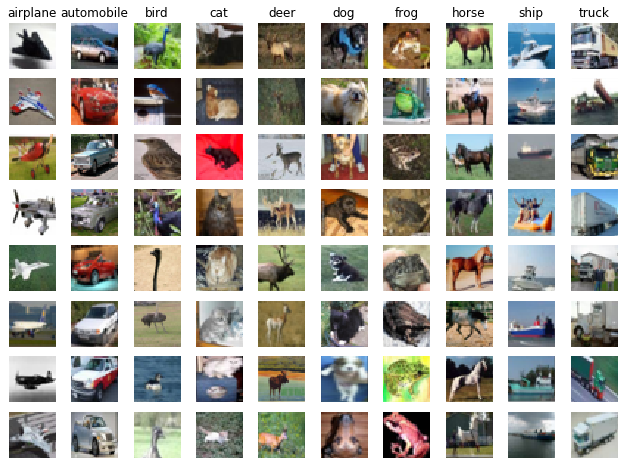

In [0]:
 def load_cifar_data():
    """
    Loads the CIFAR-10 dataset using Keras and preprocess for training.
    """
    # Download / Load the datasets
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    # Normalize the data
    y_train = to_categorical(y_train, 10)
    y_test  = to_categorical(y_test, 10)
    # x_train = x_train.astype('float32') / 255
    # x_test  = x_test.astype('float32') / 255
    
    # Label vector
    labels = [
        'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 
        'frog', 'horse', 'ship', 'truck'
    ]
    
    return x_train, y_train, x_test, y_test, labels

x_train, y_train, x_test, y_test, labels = load_cifar_data()

def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    f, axes = plt.subplots(n, 10, figsize=(11,8))
    
    for i in range(10):
        count = 0
        j = 0
        while count < n and j < 50000:
            if categories[j][i] == 1:
                axes[count,i].imshow(images[j,:,:,:])
                axes[count,i].axis('off')
                if count == 0:
                    axes[count,i].set_title(labels[i])
                count += 1
            j += 1

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

show_first_n_images_in_categories(8, x_train, y_train, labels, file_name = None)

The problem that we want to solve with this dataset is  image classification. For a given input image, our purpose is to build a model able to identify the class that the image belongs to.

<a id='baseline'></a>

# 3. Our baselines
 
First, we have used a very simple Convolutional Neural Network in order to get a baseline model for our classification problem. Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).   



## First Architecture

In [0]:
def create_model_baseline(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))  
  
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = Adam(learning_rate = 1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model_baseline = create_model_baseline(x_train.shape[1:], 10)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# Train the model
ret_baseline = model_baseline.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 211us/sample - loss: 1.6771 - acc: 0.4546 - val_loss: 1.2375 - val_acc: 0.5627
Epoch 2/20
50000/50000 [==============================] - 10s 195us/sample - loss: 1.0811 - acc: 0.6225 - val_loss: 1.0318 - val_acc: 0.6329
Epoch 3/20
50000/50000 [==============================] - 9s 190us/sample - loss: 0.8682 - acc: 0.6967 - val_loss: 0.9617 - val_acc: 0.6755
Epoch 4/20
50000/50000 [==============================] - 10s 193us/sample - loss: 0.7115 - acc: 0.7530 - val_loss: 1.0028 - val_acc: 0.6779
Epoch 5/20
50000/50000 [==============================] - 10s 192us/sample - loss: 0.5671 - acc: 0.8038 - val_loss: 1.0183 - val_acc: 0.6949
Epoch 6/20
50000/50000 [==============================] - 10s 192us/sample - loss: 0.4416 - acc: 0.8489 - val_loss: 1.2274 - val_acc: 0.6838
Epoch 7/20
50000/50000 [==============================] - 10s 192us/sample - loss: 0.3469 - acc: 0.8824 -

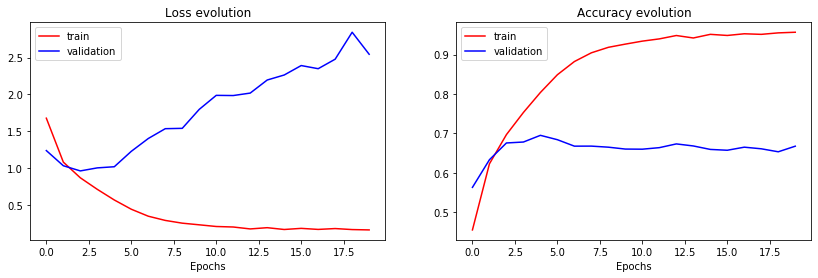

In [0]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(ret_baseline.history['loss'], label='train', color='red')
plt.plot(ret_baseline.history['val_loss'], label='validation', color='blue')
plt.title('Loss evolution')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ret_baseline.history['acc'], label='train', color='red')
plt.plot(ret_baseline.history['val_acc'], label='validation', color='blue')
plt.title('Accuracy evolution')
plt.xlabel('Epochs')
plt.legend()

# plt.grid()
plt.show()

## A Deeper CNN Model

In [0]:
def create_big_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(64, 3, padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(128, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(512, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(512, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(512))

    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = Adam(learning_rate = 1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

big_model = create_big_model(x_train.shape[1:], 10)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# Train the model
ret_big_model = big_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 26s 519us/sample - loss: 1.7331 - acc: 0.3577 - val_loss: 1.3797 - val_acc: 0.4933
Epoch 2/20
50000/50000 [==============================] - 25s 490us/sample - loss: 1.2727 - acc: 0.5421 - val_loss: 1.2237 - val_acc: 0.5679
Epoch 3/20
50000/50000 [==============================] - 25s 498us/sample - loss: 1.0629 - acc: 0.6246 - val_loss: 1.0325 - val_acc: 0.6415
Epoch 4/20
50000/50000 [==============================] - 25s 498us/sample - loss: 0.9457 - acc: 0.6703 - val_loss: 1.0214 - val_acc: 0.6471
Epoch 5/20
50000/50000 [==============================] - 26s 512us/sample - loss: 0.8708 - acc: 0.6976 - val_loss: 0.9169 - val_acc: 0.6881
Epoch 6/20
50000/50000 [==============================] - 26s 523us/sample - loss: 0.8027 - acc: 0.7238 - val_loss: 0.9471 - val_acc: 0.6878
Epoch 7/20
50000/50000 [==============================] - 26s 518us/sample - loss: 0.7650 - acc: 0.7367 

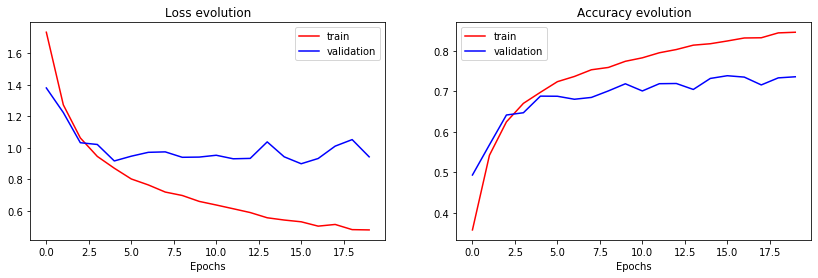

In [0]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(ret_big_model.history['loss'], label='train', color='red')
plt.plot(ret_big_model.history['val_loss'], label='validation', color='blue')
plt.title('Loss evolution')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ret_big_model.history['acc'], label='train', color='red')
plt.plot(ret_big_model.history['val_acc'], label='validation', color='blue')
plt.title('Accuracy evolution')
plt.xlabel('Epochs')
plt.legend()

# plt.grid()
plt.show()

<a id='bn'></a>

# 4. Batch Normalization
 


## Experiment 1: A Very Simple CNN Model

In [0]:
model2 = Sequential()

input_shape = x_train.shape[1:]
num_classes = y_train.shape[1]

model2.add(Conv2D(32, 3, padding='same', input_shape=input_shape))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(32,3))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=2))

model2.add(Conv2D(64, 3, padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(64,3))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=2))

model2.add(Flatten())
model2.add(Dense(512))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

opt = Adam(learning_rate = 1e-3)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
with_batch_pretrain_loss = model2.evaluate(x_train, y_train)[0]
with_batch = model2.fit(x_train, y_train, batch_size = 32, epochs = 20, validation_data = (x_test, y_test))

50000/50000 [==============================] - 6s 112us/sample - loss: 12.3496 - acc: 0.1096
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 13s 251us/sample - loss: 1.1449 - acc: 0.5959 - val_loss: 1.0514 - val_acc: 0.6367
Epoch 2/20
50000/50000 [==============================] - 12s 243us/sample - loss: 0.7414 - acc: 0.7405 - val_loss: 1.0898 - val_acc: 0.6433
Epoch 3/20
50000/50000 [==============================] - 12s 236us/sample - loss: 0.5788 - acc: 0.7967 - val_loss: 0.8697 - val_acc: 0.7039
Epoch 4/20
50000/50000 [==============================] - 12s 242us/sample - loss: 0.4544 - acc: 0.8414 - val_loss: 0.7624 - val_acc: 0.7517
Epoch 5/20
50000/50000 [==============================] - 12s 237us/sample - loss: 0.3414 - acc: 0.8828 - val_loss: 0.7299 - val_acc: 0.7690
Epoch 6/20
50000/50000 [==============================] - 12s 236us/sample - loss: 0.2557 - acc: 0.9134 - val_loss: 0.7561 - val_acc: 0.7655
Epoch 7/20


In [0]:
model3 = Sequential()

input_shape = x_train.shape[1:]
num_classes = y_train.shape[1]

model3.add(Conv2D(32, 3, padding='same', input_shape=input_shape))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(32, 3))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=2))

model3.add(Conv2D(64, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(64, 3))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=2))

model3.add(Flatten())
model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(Dense(num_classes))
model3.add(Activation('softmax'))

opt = Adam(learning_rate = 1e-3)
model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
batch_after_pretrain_loss = model3.evaluate(x_train, y_train)[0]
batch_after = model3.fit(x_train, y_train, batch_size = 32, epochs = 20, validation_data = (x_test, y_test))

50000/50000 [==============================] - 6s 121us/sample - loss: 47.6285 - acc: 0.1000
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 14s 273us/sample - loss: 1.2739 - acc: 0.5597 - val_loss: 1.1102 - val_acc: 0.6218
Epoch 2/20
50000/50000 [==============================] - 12s 247us/sample - loss: 0.8376 - acc: 0.7082 - val_loss: 1.1342 - val_acc: 0.6206
Epoch 3/20
50000/50000 [==============================] - 13s 253us/sample - loss: 0.6761 - acc: 0.7649 - val_loss: 0.8923 - val_acc: 0.6897
Epoch 4/20
50000/50000 [==============================] - 12s 243us/sample - loss: 0.5428 - acc: 0.8106 - val_loss: 0.7572 - val_acc: 0.7485
Epoch 5/20
50000/50000 [==============================] - 12s 247us/sample - loss: 0.4420 - acc: 0.8453 - val_loss: 0.7615 - val_acc: 0.7487
Epoch 6/20
50000/50000 [==============================] - 12s 248us/sample - loss: 0.3359 - acc: 0.8846 - val_loss: 0.7307 - val_acc: 0.7732
Epoch 7/20


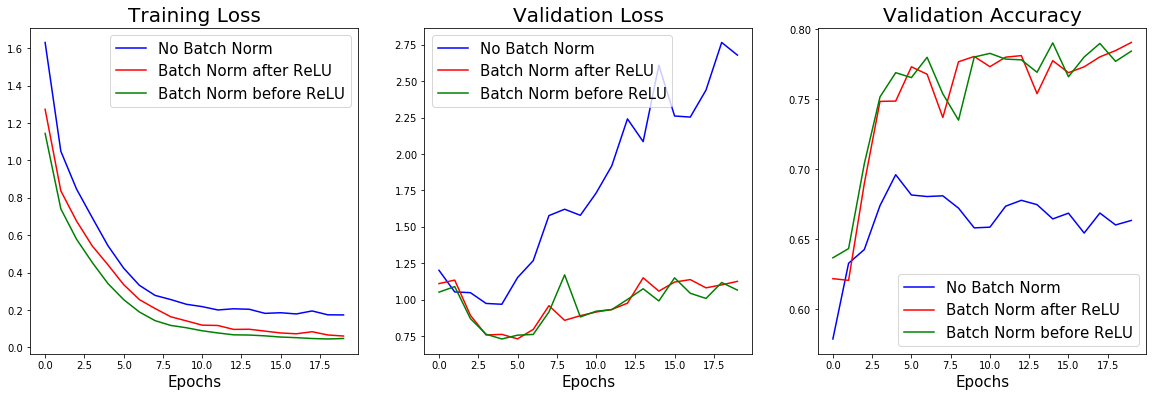

In [0]:
plt.subplot(1, 3, 1)

batch_after_act_loss = batch_after.history['loss']

batch_before_act_loss= with_batch.history['loss']
                             
no_batch_loss = ret_baseline.history['loss']


plt.plot(np.arange(20), no_batch_loss, label = 'No Batch Norm', color = 'b')                         
plt.plot(np.arange(20), batch_after_act_loss, label = 'Batch Norm after ReLU', color = 'r')
plt.plot(np.arange(20), batch_before_act_loss, label = 'Batch Norm before ReLU', color = 'g')
plt.legend(fontsize = 15)
plt.xlabel('Epochs', size = 15)
plt.title('Training Loss', size = 20)

plt.subplot(1, 3, 2)

batch_after_act_loss = batch_after.history['val_loss']

batch_before_act_loss= with_batch.history['val_loss']
                             
no_batch_loss = ret_baseline.history['val_loss']

                         

plt.plot(np.arange(20), no_batch_loss, label = 'No Batch Norm', color = 'b')                         
plt.plot(np.arange(20), batch_after_act_loss, label = 'Batch Norm after ReLU', color = 'r')
plt.plot(np.arange(20), batch_before_act_loss, label = 'Batch Norm before ReLU', color = 'g')
plt.legend(fontsize = 15)
plt.xlabel('Epochs', size = 15)
plt.title('Validation Loss', size = 20)


plt.subplot(1, 3, 3)

batch_after_act_loss = batch_after.history['val_acc']

batch_before_act_loss= with_batch.history['val_acc']
                             
no_batch_loss = ret_baseline.history['val_acc']

                         

plt.plot(np.arange(20), no_batch_loss, label = 'No Batch Norm', color = 'b')                         
plt.plot(np.arange(20), batch_after_act_loss, label = 'Batch Norm after ReLU', color = 'r')
plt.plot(np.arange(20), batch_before_act_loss, label = 'Batch Norm before ReLU', color = 'g')
plt.legend(fontsize = 15)
plt.xlabel('Epochs', size = 15)
plt.title('Validation Accuracy', size = 20)

fig = plt.gcf()
fig.set_size_inches((20,6))
fig.savefig('batch_norm_experiment1.jpg', dpi = 300, bbox_inches='tight', orientation = 'landscape')


In [0]:
import pickle 

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [0]:
histories = {}
histories['batch_after'] = batch_after.history
histories['batch_before'] = with_batch.history
histories['no_batch'] = ret_baseline.history

save_obj(histories, 'batch_norm_experiment1')

## Experiment 2: A Deeper CNN Model

In [0]:
big_model_with_batch = Sequential()

input_shape = x_train.shape[1:]
num_classes = y_train.shape[1]

big_model_with_batch.add(Conv2D(64, 3, padding='same', input_shape=input_shape))
big_model_with_batch.add(BatchNormalization())
big_model_with_batch.add(Activation('relu'))
big_model_with_batch.add(Conv2D(64, 3, padding='same'))
big_model_with_batch.add(BatchNormalization())
big_model_with_batch.add(Activation('relu'))
big_model_with_batch.add(MaxPooling2D(pool_size=2))

big_model_with_batch.add(Conv2D(128, 3, padding='same'))
big_model_with_batch.add(BatchNormalization())
big_model_with_batch.add(Activation('relu'))
big_model_with_batch.add(Conv2D(128, 3, padding='same'))
big_model_with_batch.add(BatchNormalization())
big_model_with_batch.add(Activation('relu'))
big_model_with_batch.add(MaxPooling2D(pool_size=2))

big_model_with_batch.add(Conv2D(256, 3, padding='same'))
big_model_with_batch.add(BatchNormalization())
big_model_with_batch.add(Activation('relu'))
big_model_with_batch.add(Conv2D(256, 3, padding='same'))
big_model_with_batch.add(BatchNormalization())
big_model_with_batch.add(Activation('relu'))
big_model_with_batch.add(MaxPooling2D(pool_size=2))

big_model_with_batch.add(Conv2D(512, 3, padding='same'))
big_model_with_batch.add(BatchNormalization())
big_model_with_batch.add(Activation('relu'))
big_model_with_batch.add(Conv2D(512, 3, padding='same'))
big_model_with_batch.add(BatchNormalization())
big_model_with_batch.add(Activation('relu'))
big_model_with_batch.add(MaxPooling2D(pool_size=2))


big_model_with_batch.add(Flatten())
big_model_with_batch.add(Dense(512))
big_model_with_batch.add(BatchNormalization())
big_model_with_batch.add(Activation('relu'))
big_model_with_batch.add(Dense(512))
big_model_with_batch.add(BatchNormalization())
big_model_with_batch.add(Activation('relu'))
big_model_with_batch.add(Dense(num_classes))
big_model_with_batch.add(Activation('softmax'))

opt = Adam(learning_rate = 1e-3)
big_model_with_batch.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
big_model_with_batch_history = big_model_with_batch.fit(x_train, y_train, batch_size = 32, epochs = 20, validation_data = (x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 26s 526us/sample - loss: 1.1924 - acc: 0.5767 - val_loss: 2.7305 - val_acc: 0.3786
Epoch 2/20
50000/50000 [==============================] - 24s 490us/sample - loss: 0.7527 - acc: 0.7407 - val_loss: 0.9379 - val_acc: 0.6687
Epoch 3/20
50000/50000 [==============================] - 25s 490us/sample - loss: 0.5796 - acc: 0.8025 - val_loss: 0.6719 - val_acc: 0.7723
Epoch 4/20
50000/50000 [==============================] - 25s 493us/sample - loss: 0.4679 - acc: 0.8401 - val_loss: 0.9735 - val_acc: 0.7069
Epoch 5/20
50000/50000 [==============================] - 24s 490us/sample - loss: 0.3662 - acc: 0.8758 - val_loss: 0.6537 - val_acc: 0.7868
Epoch 6/20
50000/50000 [==============================] - 25s 490us/sample - loss: 0.2839 - acc: 0.9027 - val_loss: 0.5567 - val_acc: 0.8234
Epoch 7/20
50000/50000 [==============================] - 25s 490us/sample - loss: 0.2093 - acc: 0.9277 

In [0]:
big_model_with_batch_after = Sequential()

input_shape = x_train.shape[1:]
num_classes = y_train.shape[1]

big_model_with_batch_after.add(Conv2D(64, 3, padding='same', input_shape=input_shape))
big_model_with_batch_after.add(Activation('relu'))
big_model_with_batch_after.add(BatchNormalization())

big_model_with_batch_after.add(Conv2D(64, 3, padding='same'))
big_model_with_batch_after.add(Activation('relu'))
big_model_with_batch_after.add(BatchNormalization())

big_model_with_batch_after.add(MaxPooling2D(pool_size=2))


big_model_with_batch_after.add(Conv2D(128, 3, padding='same'))
big_model_with_batch_after.add(Activation('relu'))
big_model_with_batch_after.add(BatchNormalization())

big_model_with_batch_after.add(Conv2D(128, 3, padding='same'))
big_model_with_batch_after.add(Activation('relu'))
big_model_with_batch_after.add(BatchNormalization())

big_model_with_batch_after.add(MaxPooling2D(pool_size=2))

big_model_with_batch_after.add(Conv2D(256, 3, padding='same'))
big_model_with_batch_after.add(Activation('relu'))
big_model_with_batch_after.add(BatchNormalization())

big_model_with_batch_after.add(Conv2D(256, 3, padding='same'))
big_model_with_batch_after.add(Activation('relu'))
big_model_with_batch_after.add(BatchNormalization())

big_model_with_batch_after.add(MaxPooling2D(pool_size=2))

big_model_with_batch_after.add(Conv2D(512, 3, padding='same'))
big_model_with_batch_after.add(Activation('relu'))
big_model_with_batch_after.add(BatchNormalization())

big_model_with_batch_after.add(Conv2D(512, 3, padding='same'))
big_model_with_batch_after.add(Activation('relu'))
big_model_with_batch_after.add(BatchNormalization())

big_model_with_batch_after.add(MaxPooling2D(pool_size=2))


big_model_with_batch_after.add(Flatten())

big_model_with_batch_after.add(Dense(512))
big_model_with_batch_after.add(Activation('relu'))
big_model_with_batch_after.add(BatchNormalization())

big_model_with_batch_after.add(Dense(512))
big_model_with_batch_after.add(Activation('relu'))
big_model_with_batch_after.add(BatchNormalization())

big_model_with_batch_after.add(Dense(num_classes))
big_model_with_batch_after.add(Activation('softmax'))

opt = Adam(learning_rate = 1e-3)
big_model_with_batch_after.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
big_model_with_batch_after_history = big_model_with_batch_after.fit(x_train, y_train, batch_size = 32, epochs = 20, validation_data = (x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 28s 561us/sample - loss: 1.3534 - acc: 0.5206 - val_loss: 1.8531 - val_acc: 0.4841
Epoch 2/20
50000/50000 [==============================] - 26s 518us/sample - loss: 0.8240 - acc: 0.7169 - val_loss: 0.6951 - val_acc: 0.7637
Epoch 3/20
50000/50000 [==============================] - 26s 517us/sample - loss: 0.6320 - acc: 0.7874 - val_loss: 0.9131 - val_acc: 0.6970
Epoch 4/20
50000/50000 [==============================] - 26s 519us/sample - loss: 0.4968 - acc: 0.8316 - val_loss: 0.6139 - val_acc: 0.7977
Epoch 5/20
50000/50000 [==============================] - 27s 532us/sample - loss: 0.3827 - acc: 0.8711 - val_loss: 0.6084 - val_acc: 0.8011
Epoch 6/20
50000/50000 [==============================] - 27s 540us/sample - loss: 0.2810 - acc: 0.9040 - val_loss: 0.5887 - val_acc: 0.8162
Epoch 7/20
50000/50000 [==============================] - 27s 534us/sample - loss: 0.1999 - acc: 0.9329 

In [0]:
big_model_histories = {}
big_model_histories['batch_after'] = big_model_with_batch_after_history.history
big_model_histories['batch_before'] = big_model_with_batch_history.history
big_model_histories['no_batch'] = ret_big_model.history

save_obj(big_model_histories, 'batch_norm_experiment2')

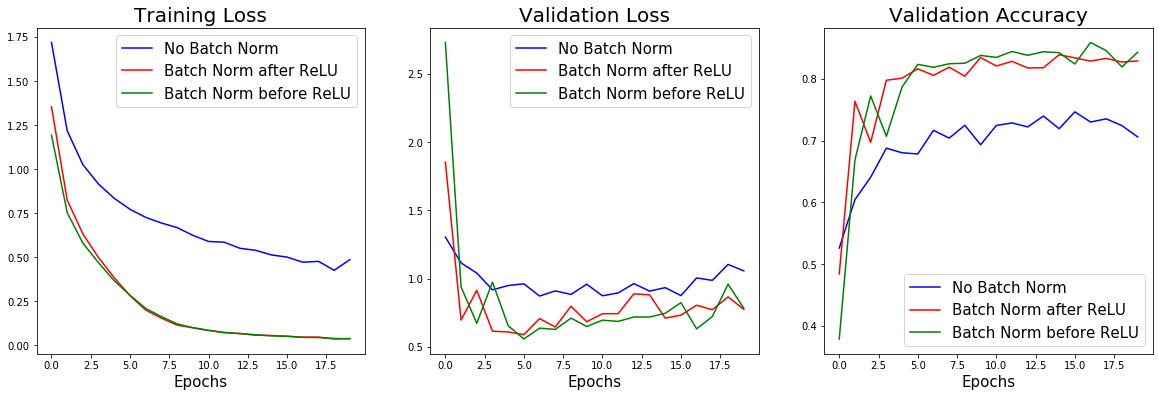

In [0]:
plt.subplot(1, 3, 1)
batch_after_act_loss = big_model_histories['batch_after']['loss']
batch_before_act_loss= big_model_histories['batch_before']['loss']                   
no_batch_loss = big_model_histories['no_batch']['loss']

plt.plot(np.arange(20), no_batch_loss, label = 'No Batch Norm', color = 'b')                         
plt.plot(np.arange(20), batch_after_act_loss, label = 'Batch Norm after ReLU', color = 'r')
plt.plot(np.arange(20), batch_before_act_loss, label = 'Batch Norm before ReLU', color = 'g')
plt.legend()
plt.legend(fontsize = 15)
plt.xlabel('Epochs', size = 15)
plt.title('Training Loss', size = 20)



plt.subplot(1, 3, 2)
batch_after_act_loss = big_model_histories['batch_after']['val_loss']
batch_before_act_loss= big_model_histories['batch_before']['val_loss']                            
no_batch_loss = big_model_histories['no_batch']['val_loss']
       
plt.plot(np.arange(20), no_batch_loss, label = 'No Batch Norm', color = 'b')                         
plt.plot(np.arange(20), batch_after_act_loss, label = 'Batch Norm after ReLU', color = 'r')
plt.plot(np.arange(20), batch_before_act_loss, label = 'Batch Norm before ReLU', color = 'g')
plt.legend(fontsize = 15)
plt.xlabel('Epochs', size = 15)
plt.title('Validation Loss', size = 20)



plt.subplot(1, 3, 3)
batch_after_act_loss = big_model_histories['batch_after']['val_acc']
batch_before_act_loss= big_model_histories['batch_before']['val_acc']                        
no_batch_loss = big_model_histories['no_batch']['val_acc']

                         
plt.plot(np.arange(20), no_batch_loss, label = 'No Batch Norm', color = 'b')                         
plt.plot(np.arange(20), batch_after_act_loss, label = 'Batch Norm after ReLU', color = 'r')
plt.plot(np.arange(20), batch_before_act_loss, label = 'Batch Norm before ReLU', color = 'g')
plt.legend(fontsize = 15)
plt.title('Validation Accuracy', size = 20)
plt.xlabel('Epochs', size = 15)
fig = plt.gcf()
fig.set_size_inches((20,6))
fig.savefig('batch_norm_experiment2.jpg', dpi = 300, bbox_inches='tight', orientation = 'landscape')

## Experiment 3: A Residual Network Model

In [0]:

from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 100
data_augmentation = False
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, batch_normalization = False)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             batch_normalization = False,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             batch_normalization = False,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model




model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)


In [0]:

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


resnet_no_batch = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            shuffle=True,
                            callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


resnet_with_batch = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            shuffle=True,
                            callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [0]:
resnet_histories = {}
resnet_histories['with_batch'] = resnet_with_batch.history
resnet_histories['no_batch'] = resnet_no_batch.history

save_obj(big_model_histories, 'batch_norm_experiment3')

In [0]:
plt.subplot(1, 3, 1)
batch_before_act_loss = resnet_histories['with_batch']['loss']
no_batch_loss= resnet_histories['no_batch']['loss']                   

plt.plot(np.arange(100), no_batch_loss, label = 'No Batch Norm', color = 'b')                         
plt.plot(np.arange(100), batch_before_act_loss, label = 'Batch Norm before ReLU', color = 'g')
plt.legend()
plt.legend(fontsize = 15)
plt.xlabel('Epochs', size = 15)
plt.title('Training Loss', size = 20)



plt.subplot(1, 3, 2)
batch_before_act_loss = resnet_histories['with_batch']['val_loss']
no_batch_loss= resnet_histories['no_batch']['val_loss']                   

plt.plot(np.arange(100), no_batch_loss, label = 'No Batch Norm', color = 'b')                         
plt.plot(np.arange(100), batch_before_act_loss, label = 'Batch Norm before ReLU', color = 'g')
plt.legend(fontsize = 15)
plt.xlabel('Epochs', size = 15)
plt.title('Validation Loss', size = 20)



plt.subplot(1, 3, 3)
batch_before_act_loss = resnet_histories['with_batch']['val_acc']
no_batch_loss= resnet_histories['no_batch']['val_acc']                   

plt.plot(np.arange(100), no_batch_loss, label = 'No Batch Norm', color = 'b')                         
plt.plot(np.arange(100), batch_before_act_loss, label = 'Batch Norm before ReLU', color = 'g')
plt.legend(fontsize = 15)
plt.title('Validation Accuracy', size = 20)
plt.xlabel('Epochs', size = 15)
fig = plt.gcf()
fig.set_size_inches((20,6))
fig.savefig('batch_norm_experiment3.jpg', dpi = 300, bbox_inches='tight', orientation = 'landscape')

<a id='dropout'></a>

# 5.  Dropout


## Experiment 1 : A Very Simple CNN Model

In [0]:
from tensorflow.keras.layers import Dropout
def create_model_dropout(input_shape, num_classes, rate=0.2):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3,3)))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Dropout(rate))
    model.add(Activation('softmax'))

    opt = Adam(learning_rate = 1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model_dropout = create_model_dropout(x_train.shape[1:], y_train.shape[1], rate=0.2)

In [0]:
ret_dropout = model_dropout.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 13s 261us/sample - loss: 2.2465 - acc: 0.2929 - val_loss: 1.6718 - val_acc: 0.4504
Epoch 2/20
50000/50000 [==============================] - 11s 229us/sample - loss: 1.5845 - acc: 0.4337 - val_loss: 1.4839 - val_acc: 0.5140
Epoch 3/20
50000/50000 [==============================] - 11s 226us/sample - loss: 1.4388 - acc: 0.4899 - val_loss: 1.2046 - val_acc: 0.6078
Epoch 4/20
50000/50000 [==============================] - 11s 226us/sample - loss: 1.3263 - acc: 0.5306 - val_loss: 1.1109 - val_acc: 0.6331
Epoch 5/20
50000/50000 [==============================] - 11s 225us/sample - loss: 1.2671 - acc: 0.5532 - val_loss: 1.0535 - val_acc: 0.6548
Epoch 6/20
50000/50000 [==============================] - 11s 229us/sample - loss: 1.2128 - acc: 0.5695 - val_loss: 1.1006 - val_acc: 0.6358
Epoch 7/20
50000/50000 [==============================] - 12s 230us/sample - loss: 1.1769 - acc: 0.5826 

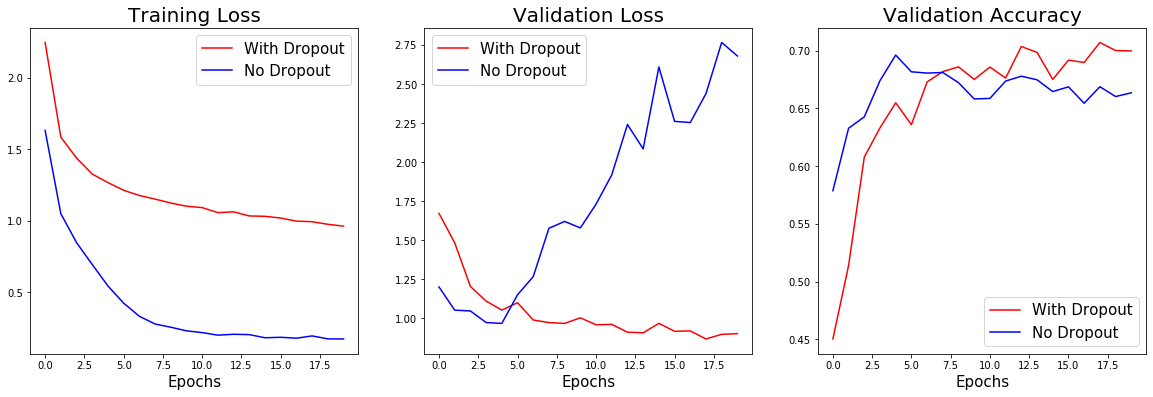

In [0]:
# plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(np.arange(20), ret_dropout.history['loss'], label='With Dropout', color='red')
plt.plot(np.arange(20), ret_baseline.history['loss'], label='No Dropout', color='blue')
plt.title('Training Loss', size=20)
plt.xlabel('Epochs', size=15)
plt.legend(fontsize=15)

plt.subplot(1, 3, 2)
plt.plot(np.arange(20), ret_dropout.history['val_loss'], label='With Dropout', color='red')
plt.plot(np.arange(20), ret_baseline.history['val_loss'], label='No Dropout', color='blue')
plt.title('Validation Loss', size=20)
plt.xlabel('Epochs', size=15)
plt.legend(fontsize=15)

plt.subplot(1, 3, 3)
plt.plot(np.arange(20), ret_dropout.history['val_acc'], label='With Dropout', color='red')
plt.plot(np.arange(20), ret_baseline.history['val_acc'], label='No Dropout', color='blue')
plt.title('Validation Accuracy', size=20)
plt.xlabel('Epochs', size=15)
plt.legend(fontsize=15)

fig = plt.gcf()
fig.set_size_inches((20,6))
fig.savefig('dropout_experiment1.jpg', dpi = 300, bbox_inches='tight', orientation = 'landscape')

## Experiment 2 : A Deeper CNN Model

In [0]:
def create_big_model_dropout(input_shape, num_classes, rate=0.2):
    model = Sequential()

    model.add(Conv2D(64, 3, padding='same', input_shape=input_shape))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, padding='same'))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(128, 3, padding='same'))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, padding='same'))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(256, 3, padding='same'))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(Conv2D(256, 3, padding='same'))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(512, 3, padding='same'))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(Conv2D(512, 3, padding='same'))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(rate))
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(Dropout(rate))
    model.add(Activation('relu'))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = Adam(learning_rate = 1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

big_model_dropout = create_big_model_dropout(x_train.shape[1:], 10, 0.1)

In [0]:
ret_big_model_dropout = big_model_dropout.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 31s 613us/sample - loss: 1.9567 - acc: 0.2590 - val_loss: 1.5251 - val_acc: 0.4234
Epoch 2/20
50000/50000 [==============================] - 30s 609us/sample - loss: 1.4493 - acc: 0.4618 - val_loss: 1.3623 - val_acc: 0.4999
Epoch 3/20
50000/50000 [==============================] - 31s 625us/sample - loss: 1.2633 - acc: 0.5508 - val_loss: 1.1475 - val_acc: 0.5952
Epoch 4/20
50000/50000 [==============================] - 31s 629us/sample - loss: 1.1552 - acc: 0.5926 - val_loss: 1.1246 - val_acc: 0.6097
Epoch 5/20
50000/50000 [==============================] - 31s 622us/sample - loss: 1.0950 - acc: 0.6187 - val_loss: 1.1419 - val_acc: 0.6006
Epoch 6/20
50000/50000 [==============================] - 31s 625us/sample - loss: 1.0723 - acc: 0.6298 - val_loss: 1.0181 - val_acc: 0.6556
Epoch 7/20
50000/50000 [==============================] - 31s 625us/sample - loss: 1.0437 - acc: 0.6411 

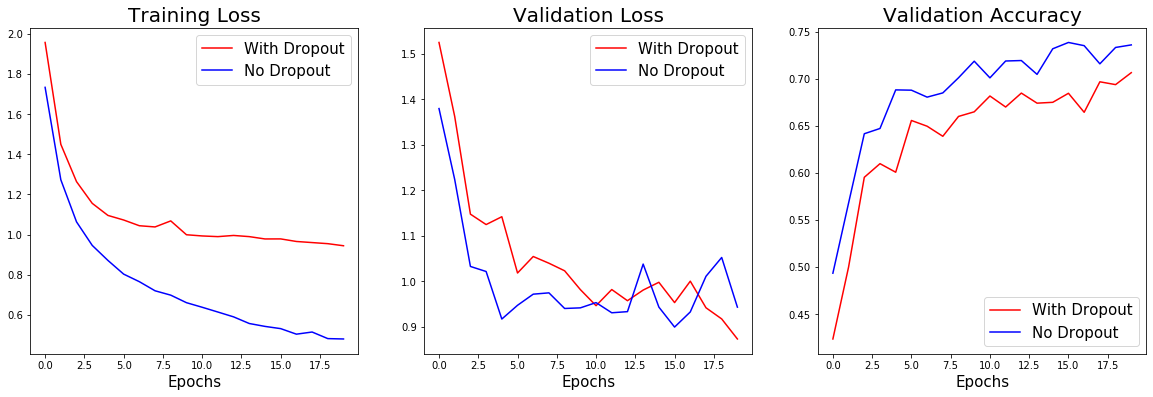

In [0]:
# plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(np.arange(20), ret_big_model_dropout.history['loss'], label='With Dropout', color='red')
plt.plot(np.arange(20), ret_big_model.history['loss'], label='No Dropout', color='blue')
plt.title('Training Loss', size=20)
plt.xlabel('Epochs', size=15)
plt.legend(fontsize=15)

plt.subplot(1, 3, 2)
plt.plot(np.arange(20), ret_big_model_dropout.history['val_loss'], label='With Dropout', color='red')
plt.plot(np.arange(20), ret_big_model.history['val_loss'], label='No Dropout', color='blue')
plt.title('Validation Loss', size=20)
plt.xlabel('Epochs', size=15)
plt.legend(fontsize=15)

plt.subplot(1, 3, 3)
plt.plot(np.arange(20), ret_big_model_dropout.history['val_acc'], label='With Dropout', color='red')
plt.plot(np.arange(20), ret_big_model.history['val_acc'], label='No Dropout', color='blue')
plt.title('Validation Accuracy', size=20)
plt.xlabel('Epochs', size=15)
plt.legend(fontsize=15)

fig = plt.gcf()
fig.set_size_inches((20,6))
fig.savefig('dropout_experiment2.jpg', dpi = 300, bbox_inches='tight', orientation = 'landscape')